# **XAI-Methoden angewendet auf den Review (Event-basiert) Datensatz**



## Packages installieren
 

In [1]:
%%capture
!pip install torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu111.html
!pip install torch-geometric==1.7.2

In [2]:
%%capture
#!pip install dive-into-graphs

In [3]:
%%capture
!git clone https://github.com/divelab/DIG.git
%cd DIG
!pip install .

In [4]:
%%capture
!pip install pm4py

In [5]:
# Hauptordner-Pfad
import torch
from pathlib import Path
path = Path("/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM")
%cd "/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM" 

/content/drive/MyDrive/Rep_Masterarbeit/XAI_GNN_BPM


In [6]:
%load_ext autoreload
%autoreload 2

In [7]:
import torch
import joblib
from preprocessing.loanApplication import *
from preprocessing.reviewSynthetic import *
from models.gcn3_neu import *

from torch_geometric.data.batch import Batch
from dig.xgraph.evaluation import XCollector
import tqdm as tqdm
import math

from dig.xgraph.method import PGExplainer
from dig.xgraph.method import GradCAM
from dig.xgraph.method import GNNExplainer
from utilities import RandomExplainer
from utilities_xai import train_pgexplainer, pgexplainer_run, gradcam_run, gnnexplainer_run, random_node_run, split_dataset_2_8, prediction_check
from train_gcn import load_gcn

from utilities import *


In [8]:
# Verwendete Laufzeit-Umgebung definieren (GPU oder CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Review Datensatz

### Datensatz laden 

In [9]:
# Laden eines Vorverarbeiteten Datensatzes
dataset_name = "loan_all_events_fall_ohe_wEvents_5_2"
dataset = torch.load(path / str("datasets/dataset_" + dataset_name))
feature  = joblib.load("datasets/encoder_" + dataset_name + ".joblib") 

In [10]:
dataset = dataset[0]
#feature = feature[0]

In [11]:
ds_train, ds_test = split_dataset_2_8(dataset)

##Variablen

Hier sind alle Variablen zusammengefasst. Vor Ausführen der Datei können hier Konfigurationen vorgenommen werden

In [12]:

# ---------------------------Trainingsdatensatz ------------------------
test_len = 300

# ---------------------------Variablen Model---------------------------
hidden_channel = 100
input_dim = dataset[0].x.shape[1]

model_name = f"{dataset_name}_{str(0)}"

# ---------------------------Variablen XAI Methoden---------------------------
#sparsity = 0.6    # Spärlichkeit: Wie viel Prozent des ursprünglichen Graphen aus der Erklärung ausgeschlossen werden soll
num_classes =  2  # Anzahl der Klassen: 0: Review wurde angenommen, 1: Review wurde abgelehnt
# PGExpaleiner
# pgexplainer_training = True # Soll der PGExplainer neu Trainiert werden (True für Ja)
#path_pgexplainer =  path / "xai_methods/pgexplainer/trainiert" # Speicherort für Parameter des PGExplainer
pgexplainer_name = f"{dataset_name}/pgexplainer" # Speicherort für Parameter des PGExplainer
# GGNN-Explainer


#fast_test = ds_test[:test_len]

## XAI Methoden

In [13]:
# Nur richtige Vorhersagen des Models beachten
model = load_gcn(model_name, input_dim, device, path)
fast_test = prediction_check(dataset, model, test_len, device)


In [14]:
#-----------------------------------------------------------------xCollector----------------------------------------------------------------
# Listen in welchen xCollectoren für die vordefinierten Sparsity-Werte gespeichert werden

collector_list_gradcam = []
collector_list_gnnexplainer = []
collector_list_pgexplainer = []
collector_list_random_node = []


# Erstellen einer Liste von Sparsity-Werten 
steps = np.linspace(0.5,1,5,endpoint=False)
# Instantiieren der xCollectoren für unterschiedliche Sparsity-Werte 
for sparsity in steps:
  collector_list_gradcam.append(XCollector())
  collector_list_gnnexplainer.append(XCollector())
  collector_list_pgexplainer.append(XCollector())
  collector_list_random_node.append(XCollector())

### Random Node

In [ ]:
random_explainer = RandomExplainer()
model = load_gcn(model_name, input_dim, device, path)
print("--------------Random-Node--------------------")
for data in tqdm.tqdm(fast_test):  
  data = data.to(device)
  collector_list_random_node = random_node_run(data, collector_list_random_node, random_explainer, steps, model)

--------------Random-Node--------------------


100%|██████████| 300/300 [00:14<00:00, 21.37it/s]


###PGExplainer



In [ ]:
param = {
    "lr": 0.05,
    "coff_size": 0.005, 
    "coff_ent": 0.0005, 
    "t0": 5.0,
    "t1": 1.0,
    "epochs": 20}

In [ ]:
model = load_gcn(model_name, input_dim, device, path)
explainer_pge = PGExplainer(model, hidden_channel*2, device = device, epochs = param["epochs"], lr = param["lr"], coff_ent = param["coff_ent"] , coff_size = param["coff_size"] , t0 = param["t0"] , t1 = param["t1"] )
explainer_pge = train_pgexplainer(explainer_pge, False, ds_train, path, pgexplainer_name)
print("--------------PGExplainer--------------------")
for data in tqdm.tqdm(fast_test):  
  data = data.to(device) 
  collector_list_pgexplainer = pgexplainer_run(data, collector_list_pgexplainer, explainer_pge, steps)

--------------PGExplainer--------------------


100%|██████████| 300/300 [00:24<00:00, 12.43it/s]


###GNN Explainer

In [22]:
param_gnnexplainer = {
    "lr": 0.001,    
    "epochs": 600
}

In [23]:
model = load_gcn(model_name, input_dim, device, path)
explainer_gnnexplainer = GNNExplainer(model, epochs=param_gnnexplainer["epochs"], lr=param_gnnexplainer["lr"], explain_graph=True) 
print("--------------GNN-Explainer--------------------")
for data in tqdm.tqdm(fast_test):  
  data = data.to(device)
  collector_list_gnnexplainer = gnnexplainer_run(data, collector_list_gnnexplainer, explainer_gnnexplainer, steps)
#explainer_gnnexplainer.__clear_masks__()


--------------GNN-Explainer--------------------


100%|██████████| 300/300 [2:06:37<00:00, 25.32s/it]


In [24]:
sparsity_fidelity_gnnexplainer = [x.fidelity for x in collector_list_gnnexplainer]
sparsity_fidelity_inv_gnnexplainer = [x.fidelity_inv for x in collector_list_gnnexplainer]
sparsity_gnnexplainer = [x.sparsity for x in collector_list_gnnexplainer]

### Grad-Cam

In [ ]:
model = load_gcn(model_name, input_dim, device, path)
explainer_grad_cam = GradCAM(model, explain_graph=True)
print("--------------Grad-Cam--------------------")
for data in tqdm.tqdm(fast_test):
  
  data = data.to(device)
  collector_list_gradcam = gradcam_run(data, collector_list_gradcam, explainer_grad_cam, steps)

--------------Grad-Cam--------------------


  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/captum/attr/_utils/gradient.py:33: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  "required_grads has been set automatically." % index
100%|██████████| 300/300 [00:48<00:00,  6.21it/s]


## Visualisierung der Ergebnisse

In [15]:
from utilities_xai import load_eval_results, plot_results_prefix, plot_results_load

In [21]:
grad_cam_results, gnnexplainer_results, pgexplainer_results, ranodm_node_results = load_eval_results(path / f"xai_results/{dataset_name}")

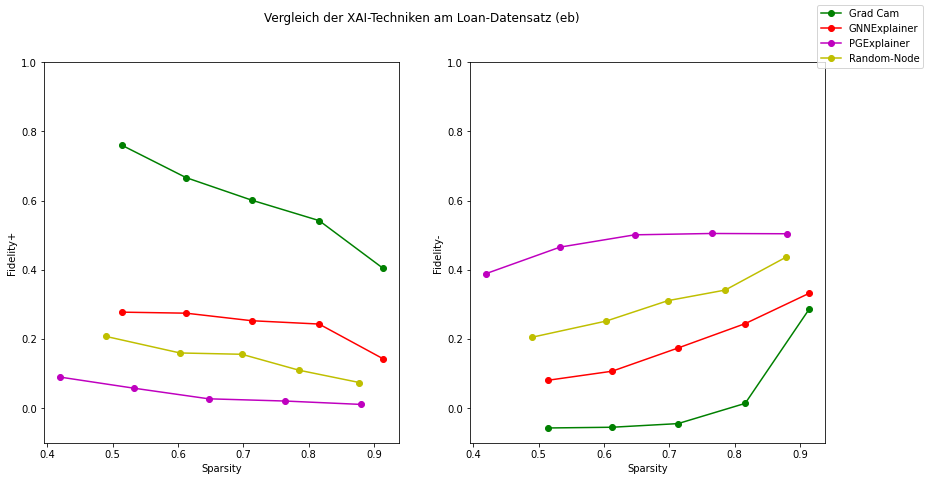

In [28]:
plot_results_load("Vergleich der XAI-Techniken am Loan-Datensatz (eb)", path / f"xai_results/{dataset_name}", grad_cam_results[0], grad_cam_results[1], grad_cam_results[2], \
     sparsity_fidelity_gnnexplainer,sparsity_fidelity_inv_gnnexplainer,sparsity_gnnexplainer, \
        pgexplainer_results[0], pgexplainer_results[1], pgexplainer_results[2], \
          ranodm_node_results[0], ranodm_node_results[1], ranodm_node_results[2])

PGExplainer: Tuning zeigt, dass PGExplainer bei fallendem Loss im Training schlechtere Evaluations-Ergebnisse erreicht. Wenn der Loss steigt, sind die Evaluations-Ergebnisse auf der anderen Seite besser. Hier wurde der PGExplainer über 20 Epochen trainiert, weshalb der Loss abgenommen hat. Interpretieren lässt sich, dass der PGExplainer die falschen Strukturen lernt. Es wurde Versucht durch das Minimieren des Losses auszuschließen dass er in suboptimalen lokalen Minima gefangen ist. 